# Trainer Demo

## Introduction
In order to facilitate training of various existing models and being able to compare them, we build a training API automatizing the training process.

The base of this training API is the notion of Trainer.
A trainer is a class that can be used to make transfer learning on a given dataset.
It will also be used for evaluation and result reporting. 


In [1]:
import tensorflow as tf
import src.features as lf
import src.models as lm


# record and report locations init
lm.models.RECORD_DIR='../models/records'
lm.models.FIGURE_DIR='../reports/figures'

/Users/olivier/pythonEnvs/tf2/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Data loading

Data are loaded from directory using a custom class which allows
- to easily create and use the model trainers
- to easily create the results report of those trainers.

In [2]:
data = lf.data_builder.create_dataset_from_directory('../data/v2-plant-seedlings-dataset/')


## Trainer exemple

We make an exemple trainer that will do transfer learning on Mobilenetv2

First we build a base model wrapper that encapsulates the characteristics of Mobilnetv2

In [3]:
class MobileNetv2(lm.model_wrapper.BaseModelWrapper) :
    def __init__(self, img_size:tuple) -> None:
        self.preprocessing = tf.keras.applications.mobilenet_v2.preprocess_input
        self.log_name = 'mobilenetv2'
        self.model = tf.keras.applications.mobilenet_v2.MobileNetV2(
                input_shape=img_size + (3,),
                include_top=False,
                alpha=1.0,
                weights='imagenet'
            )

Then we build a trainer using this MobilnetV2 wrapper

In [4]:
class ExempleTrainer(lm.models.Trainer):
    # abstract class
    record_name = "exemple"
    img_size = (128, 128)
    base_model = MobileNetv2(img_size)
    def __init__(self, data_wrapper, campaign_id):
        super().__init__(data_wrapper,campaign_id)
        x = self.base_model.model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        output = tf.keras.layers.Dense(12, activation='softmax', name='main')(x)
        self.model = tf.keras.Model(inputs=self.base_model.model.input, outputs=output)

    def process_training(self):
        self.base_model.model.trainable = False
        self.compile_fit(lr=0.001, epochs=5)

## Training
The trainer is then used to build the data flows and train the model 
It will serialize it directly in the RECORD_DIR 

In [5]:
trainer = ExempleTrainer(data,'exemple')
trainer.fit_or_load(training=True)

Found 4382 validated image filenames belonging to 12 classes.
Found 597 validated image filenames belonging to 12 classes.
Found 554 validated image filenames belonging to 12 classes.
>>> exemple –– Training
Epoch 1/5


2023-11-03 10:38:20.544875: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


137/137 [==============================] - 141s 1s/step - loss: 1.9420 - categorical_accuracy: 0.3357 - val_loss: 1.3966 - val_categorical_accuracy: 0.5260 - lr: 0.0010
Epoch 2/5
137/137 [==============================] - 107s 781ms/step - loss: 1.3504 - categorical_accuracy: 0.5155 - val_loss: 1.1504 - val_categorical_accuracy: 0.6147 - lr: 0.0010
Epoch 3/5
137/137 [==============================] - 110s 802ms/step - loss: 1.1891 - categorical_accuracy: 0.5817 - val_loss: 1.0346 - val_categorical_accuracy: 0.6667 - lr: 0.0010
Epoch 4/5
137/137 [==============================] - 98s 716ms/step - loss: 1.0965 - categorical_accuracy: 0.6111 - val_loss: 1.0327 - val_categorical_accuracy: 0.6616 - lr: 0.0010
Epoch 5/5
137/137 [==============================] - 118s 864ms/step - loss: 1.0095 - categorical_accuracy: 0.6442 - val_loss: 0.9022 - val_categorical_accuracy: 0.6750 - lr: 0.0010
>>> exemple –– Serialize 


The model has been trained and serialized in the RECORD_DIR
It can be loaded with the following command

In [6]:
trainer2 = ExempleTrainer(data,'exemple')
trainer2.fit_or_load(training=False)

Found 4382 validated image filenames belonging to 12 classes.
Found 597 validated image filenames belonging to 12 classes.
Found 554 validated image filenames belonging to 12 classes.
>>> exemple –– Loading
++++++model++++++history1+++


## Evaluation
The trainer can be used to evaluate the model

In [7]:
trainer2.evaluate()

>>> exemple –– Evaluation
18/18 [==============================] - 16s 766ms/step


,filename,actual,predicted,Same
0,../data/v2-plant-seedlings-dataset/Small-flowe...,Small-flowered Cranesbill,Small-flowered Cranesbill,True
1,../data/v2-plant-seedlings-dataset/Scentless M...,Scentless Mayweed,Scentless Mayweed,True
2,../data/v2-plant-seedlings-dataset/Cleavers/30...,Cleavers,Cleavers,True
3,../data/v2-plant-seedlings-dataset/Sugar beet/...,Sugar beet,Sugar beet,True
4,../data/v2-plant-seedlings-dataset/Common Chic...,Common Chickweed,Scentless Mayweed,False
...,...,...,...,...
549,../data/v2-plant-seedlings-dataset/Fat Hen/539...,Fat Hen,Fat Hen,True
550,../data/v2-plant-seedlings-dataset/Small-flowe...,Small-flowered Cranesbill,Small-flowered Cranesbill,True
551,../data/v2-plant-seedlings-dataset/Loose Silky...,Loose Silky-bent,Loose Silky-bent,True
552,../data/v2-plant-seedlings-dataset/Common Chic...,Common Chickweed,Common Chickweed,True


Several methods can be used to analyse the results : 
* we can display the history of the training

>>> exemple –– Display training history graphs


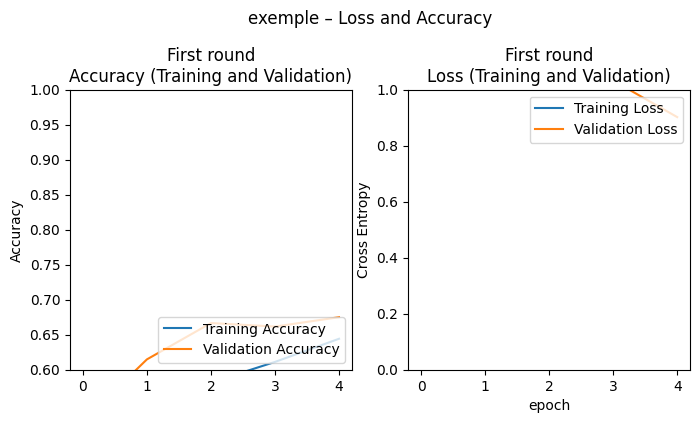

In [8]:
trainer2.display_history_graphs()

* print the classification report

In [9]:
trainer2.print_classification_report();

>>> exemple –– Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.37      0.59      0.45        29
                 Charlock       0.89      0.91      0.90        35
                 Cleavers       0.95      0.92      0.93        38
         Common Chickweed       0.77      0.62      0.69        80
             Common wheat       0.58      0.71      0.64        21
                  Fat Hen       0.58      0.69      0.63        54
         Loose Silky-bent       0.70      0.55      0.61        77
                    Maize       0.83      0.95      0.88        20
        Scentless Mayweed       0.61      0.52      0.56        52
         Shepherd’s Purse       0.60      0.14      0.22        22
Small-flowered Cranesbill       0.81      0.90      0.85        70
               Sugar beet       0.70      0.88      0.78        56

                 accuracy                           0.70       554
                macro a

In [ ]:
trainer2.display_confusion_matrix()

In [10]:
trainer2.single_prediction(data.dataframe.iloc[8].path)

>>> exemple –– Evaluation
1/1 [==============================] - 1s 1s/step


'Cleavers'

>>> exemple –– Display training data samples


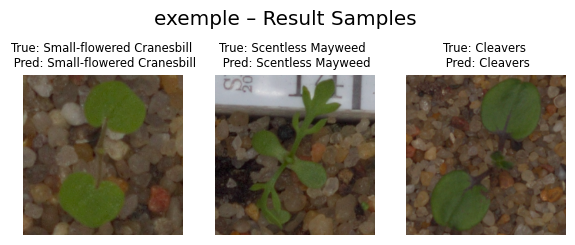

In [11]:
trainer2.display_samples(nb=3)

>>> exemple –– Display training data samples


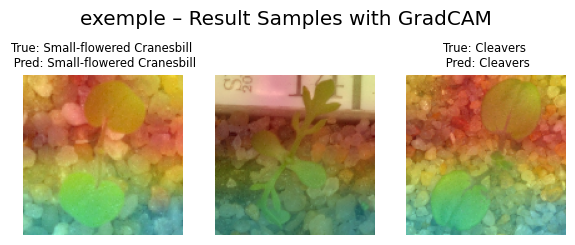

In [12]:
trainer2.display_samples(nb=3, gradcam=True,guidedGrad_cam=True)